<a href="https://colab.research.google.com/github/Brendromero/ProyectoN1-Romero/blob/main/ETL_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Limpieza de datos**

In [2]:
import pandas as pd
import json
from ast import literal_eval
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

# **I. El problema del negocio**

Trabajamos como Data Scientist en Steam, una plataforma multinacional de videojuegos y se nos ha encargado hacer un sistema de recomendacion de videojuegos para los usuarios.

Sin embargo, nos encontramos con los datos impuros. Asi que nuestro primer trabajo sera limpiar esos datos, transformarlos para un analisis mas profundo y hacer el sistema de recomendacion adecuadamente.

# **II. El set de los datos**

La información que se nos ha entregado son 3 .json.gz lo cual descomprimi anteriormente:


*   [australian_users_items.json](https://drive.google.com/file/d/1hHvKZHEa4Fyj-nWdF_fq5c28_YRhEBwb/view?usp=drive_link):
Este archivo contiene 5 columnas(user_id, items_count, steam_id, user_url e items -este ultimo tiene datos anidados-)

*   [australian_user_reviews.json](https://drive.google.com/file/d/1-EokrFjVKgZ6XXOuUV4C350dE5jIAv0v/view?usp=drive_link):
Este archivo contiene 3 columnas(user_id, user_url y reviews -este ultimo tiene datos anidados)

*   [output_steam_games.json](https://drive.google.com/file/d/11avqC7AbkFOz4IcXftBRa8CZpR4znoTb/view?usp=drive_link):
Este archivo contiene 15 columnas(publisher, genres, app_name, title, url, release_date, tags, discount_price, reviews_url, specs, price, early_access, id, developer, metascore)

* [Diccionario de datos](https://docs.google.com/spreadsheets/d/1NSlZocD5t3Mq3RaUudMmt_s8hwfQBB85/edit?usp=drive_link&ouid=117731322330287463270&rtpof=true&sd=true):
Este archivo contiene información necesaria para conocer y trabajar con los JSON entregados.

In [3]:
# Me conecto con google colab a mi drive para trabajar con los datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **II.I Lectura del json 'items'**

In [4]:
# Creo una lista vacia para luego poder agregar los datos que sacamos del dataset
row = []

with open('/content/drive/MyDrive/Datasets_entregados/australian_users_items.json', encoding="latin1") as f:
    for lines in f.readlines():
        row.append(ast.literal_eval(lines))
# Lo convierto en dataframe para visualizar mejor los datos
df_items = pd.DataFrame(row) # 3m 26s

In [5]:
print(df_items.shape)
df_items.head()
# Vemos la columna de reviews que tiene datos anidados

(88310, 5)


,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


## **II.II Desanidar los datos necesarios**

Desde nuestro diccionario y como ya he mencionado más arriba, debemos desanidar la columna 'items'. Veamos la información que nos brinda:



1.   user_id: identificador único de usuario
2.   user_url: URl de perfil del usuario
3.   items_count: Cantidad de items por usuario
4.   items: items de usuario ('iteam_id': identificador único del juego, 'item_name': nombre del juego, 'playtime_forever': horas jugadas, 'playtime_2weeks': horas jugadas dentro de las 2 semanas)

Observando las columnas que tenemos y basandome a lo que nos piden en el sistema de recomendación, tomare dos columnas de alli que considero importante para mi análisis:

*   item_id
*   item_name
*   playtime_forever

In [6]:
data_desanidada = []

for index, row in df_items.iterrows():
    user_id = row['user_id']
    items_count = row['items_count']
    steam_id = row['steam_id']
    user_url = row['user_url']
    items = row['items']

    for i in items:
        new_rows = {
            'user_id': user_id,
            'items_count': items_count,
            'steam_id': steam_id,
            'user_url': user_url,
            'item_id': i.get('item_id', ''),
            'item_name': i.get('item_name', ''),
            'playtime_forever': i.get('playtime_forever', '')
        }
        data_desanidada.append(new_rows)

items_desanidado = pd.DataFrame(data_desanidada) # Demora 30s

In [7]:
items_desanidado.head()

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0


In [8]:
# Veo cuales son las variables numericas y categoricas
items_desanidado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153209 entries, 0 to 5153208
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           object
 1   items_count       int64 
 2   steam_id          object
 3   user_url          object
 4   item_id           object
 5   item_name         object
 6   playtime_forever  int64 
dtypes: int64(2), object(5)
memory usage: 275.2+ MB


In [9]:
print(f'tamanio del set antes de eliminar las filas repetidas: {items_desanidado.shape}')
items_desanidado.drop_duplicates(inplace=True)
print(f'tamanio del set despues de eliminar las filas repetidas: {items_desanidado.shape}')

tamanio del set antes de eliminar las filas repetidas: (5153209, 7)
tamanio del set despues de eliminar las filas repetidas: (5094092, 7)


## **II.III Outliers en las variables numéricas**

* No siempre es necesario eliminar las outliers que vemos. Hay que conocer los datos y entender si esos outliers pueden perjudicarnos en el analisis o no.
* Hay que saber que queremos de esa columna y en que afectaria si dejamos esos outliers.

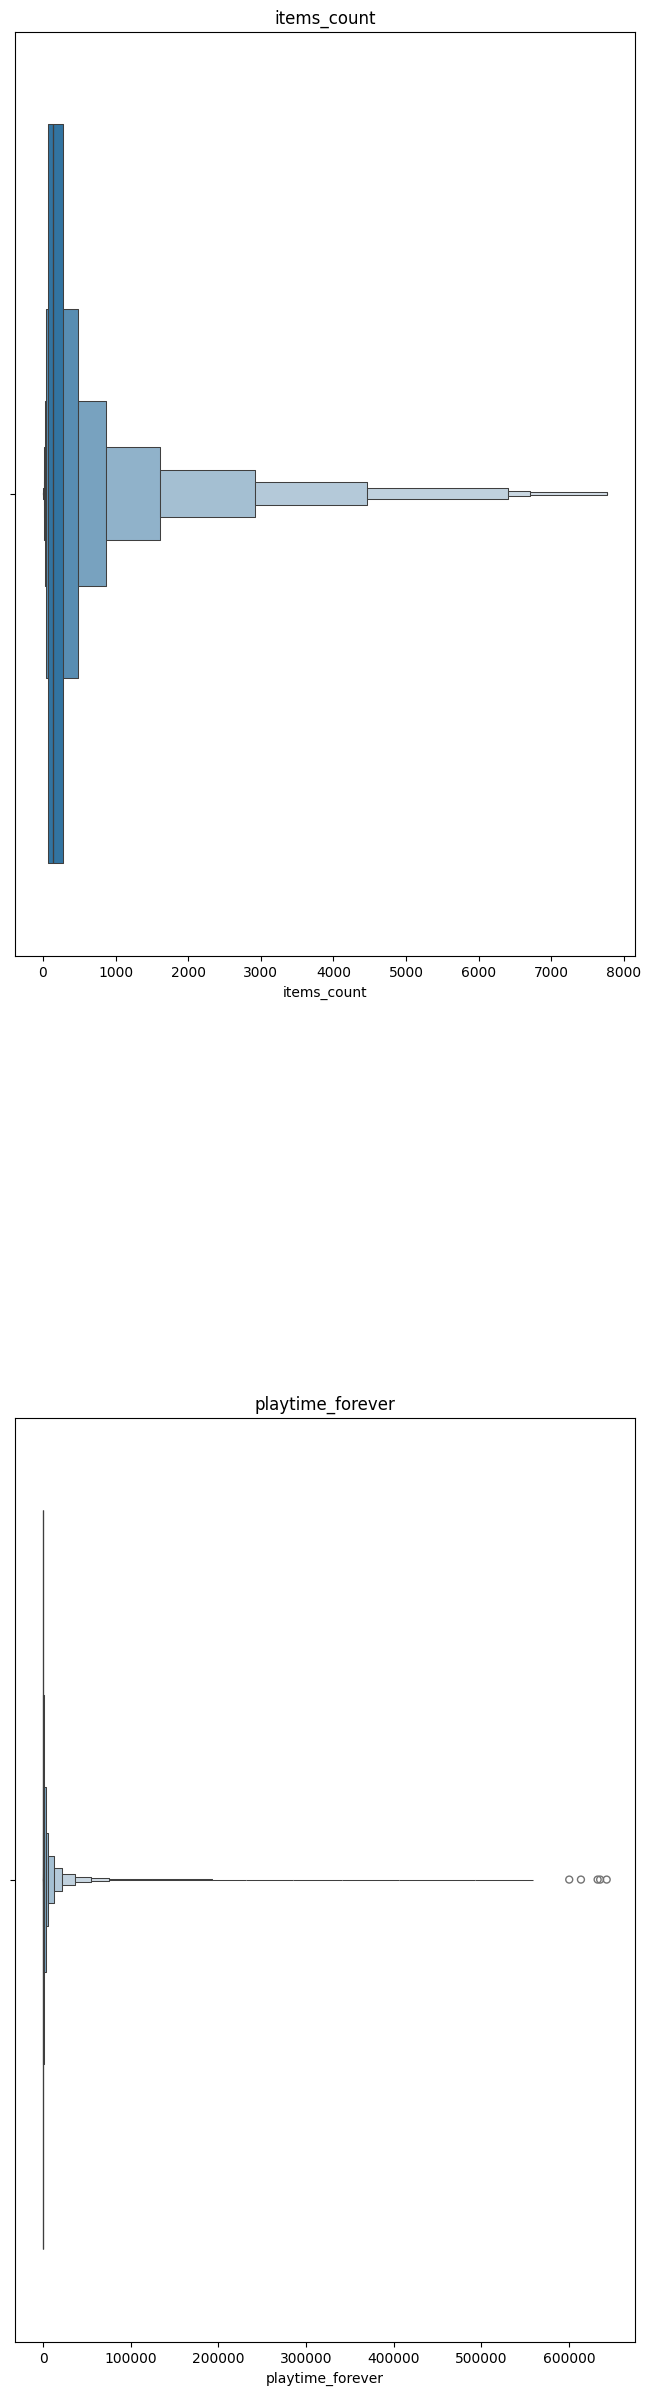

In [10]:
cols_num = ['items_count', 'playtime_forever']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,30))
fig.subplots_adjust(hspace=0.5)

for i , col in enumerate(cols_num):
  sns.boxenplot(x=col, data=items_desanidado, ax=ax[i])
  ax[i].set_title(col) # Demora 10s

En la visualización de arriba podemos observar en 'playtime_forever' que hay resultados que salen de lo común dentro de los jugadores.

Teniendo conocimiento de que la plataforma esta desde 2003 y haciendo el siguiente cálculo:

(365 * 24) / 600000 = 68.4 años

Esto sin tener en cuanta los años bisiestos. Por lo que esos datos estan mal porque la plataforma tiene poco mas de 21 años. Y calculando que jugaran las 24 horas del dia  por 21 años, estariamos llegando a los 183.960 horas

In [11]:
# Vamos a resudir esos datos a 100.000 horas
print(f'Tamaño del set antes de eliminar datos:{items_desanidado.shape}')
items1 = items_desanidado[items_desanidado['playtime_forever']<= 100000]
print(f'Tamaño del set despues de eliminar datos: {items1.shape}')

Tamaño del set antes de eliminar datos:(5094092, 7)
Tamaño del set despues de eliminar datos: (5091662, 7)


# **III. Lectura del archivo json 'Reviews'**

In [12]:
row = []

with open('/content/drive/MyDrive/Datasets_entregados/australian_user_reviews.json', encoding="latin1") as f:
    for lines in f.readlines():
        row.append(ast.literal_eval(lines))

df_reviews = pd.DataFrame(row) # Demora 6s

In [13]:
print(df_reviews.shape)
df_reviews.head()
# Vemos la columna de reviews que tiene datos anidados

(25799, 3)


,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


## **III.I Desanidar los datos**

Asi como hicimos con los datos de 'items', aca debemos hacer el mismo procedimiento con la columna 'reviews'. Veamos que tenemos en cada columna que nos pueda servir para nuestro sistema de recomendación:

1.   user_id: identificador único de usuario
2.   user_url: url del perfil del usuario
3.   reviews: reviews de usuario('funny': sin datos que especifiquen a que se refiere, 'posted': contiene fecha en formato de texto y numérico, 'last_edited': sin especificar datos, 'item_id': identificador único del juego, 'helpful': parece ser un porcentaje de los comentarios sobre el juego, 'recommend': datos booleanos, 'reviews': comentarios positivos, neutrales o negativos sobre el juego)

In [14]:
data_desanidada = []

for index, row in df_reviews.iterrows():
    user_id = row['user_id']
    user_url = row['user_url']
    reviews = row['reviews']

    for i in reviews:
        new_row = {
        'user_id': user_id,
        'user_url' : user_url,
        'posted': i.get('posted', ''),
        'item_id': i.get('item_id', ''),
        'recommend': i.get('recommend', ''),
        'sentiment_analysis': i.get('review', ''),
        }
    data_desanidada.append(new_row)

reviews_desanidado = pd.DataFrame(data_desanidada) # Demora 8s

In [15]:
reviews_desanidado.head()

,user_id,user_url,posted,item_id,recommend,sentiment_analysis
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"Posted April 21, 2011.",43110,True,Great atmosphere. The gunplay can be a bit chu...
1,js41637,http://steamcommunity.com/id/js41637,"Posted November 29, 2013.",239030,True,Very fun little game to play when your bored o...
2,evcentric,http://steamcommunity.com/id/evcentric,"Posted October 15, 2014.",224500,True,"Fun world builder, with plenty of option of ho..."
3,doctr,http://steamcommunity.com/id/doctr,"Posted February 23, 2012.",108710,True,"Alan wake is a really good game, the light eff..."
4,maplemage,http://steamcommunity.com/id/maplemage,"Posted July 11, 2013.",204300,True,"OH YES, THIS GAME IS THE BEST, THEY ADD STUFF ..."


## **III.II Analisis de sentimiento**

Uno de los endpoints que se pide para el sistema de recomendación es reemplazar la columna de review por la de sentiment_analysis. Veamos en trabajar con la columna 'sentiment_analysis' donde se pide usar NLP para aplicar un análisis de sentimiento
* '0' si es negativo,
* '1' si es neutral,
* '2' si es positivo

In [16]:
# Eliminamos los valos NaN en la columna review
reviews_desanidado = reviews_desanidado[reviews_desanidado['sentiment_analysis'].notna()]

# o rellenar con valores NaN con una cadena vacia o un texto default
reviews_desanidado['sentiment_analysis'].fillna('', inplace=True)

In [17]:
# Voy a iniciar usando vader para el analisis de sentimiento

sia = SentimentIntensityAnalyzer(lexicon_file='/content/drive/MyDrive/datasets/vader_lexicon.txt')

# Agregamos Vader a las metricas del dataframe
reviews_desanidado['compound'] = reviews_desanidado['sentiment_analysis'].apply(lambda x: sia.polarity_scores(x)['compound'])
reviews_desanidado['neg'] = reviews_desanidado['sentiment_analysis'].apply(lambda x: sia.polarity_scores(x)['neg'])
reviews_desanidado['neu'] = reviews_desanidado['sentiment_analysis'].apply(lambda x: sia.polarity_scores(x)['neu'])
reviews_desanidado['pos'] = reviews_desanidado['sentiment_analysis'].apply(lambda x: sia.polarity_scores(x)['pos']) # Demora 1m

In [18]:
reviews_copy = reviews_desanidado.copy()
# Funcion para categorizarr el sentimiento segun la puntiacion compuesta
def categorize_sentiment(compound):
    if compound >= 0.05:
        return 2
    elif compound <= 0.05:
        return 0
    else:
        return 1

reviews_copy['sentiment_analysis'] = reviews_copy['compound'].apply(categorize_sentiment)

reviews_copy

,user_id,user_url,posted,item_id,recommend,sentiment_analysis,compound,neg,neu,pos
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"Posted April 21, 2011.",43110,True,2,0.9117,0.000,0.704,0.296
1,js41637,http://steamcommunity.com/id/js41637,"Posted November 29, 2013.",239030,True,2,0.7713,0.081,0.541,0.378
2,evcentric,http://steamcommunity.com/id/evcentric,"Posted October 15, 2014.",224500,True,2,0.5106,0.093,0.643,0.264
3,doctr,http://steamcommunity.com/id/doctr,"Posted February 23, 2012.",108710,True,2,0.9571,0.000,0.738,0.262
4,maplemage,http://steamcommunity.com/id/maplemage,"Posted July 11, 2013.",204300,True,2,0.9939,0.071,0.313,0.616
...,...,...,...,...,...,...,...,...,...,...
25794,76561198306599751,http://steamcommunity.com/profiles/76561198306...,Posted May 31.,261030,True,2,0.8015,0.161,0.493,0.345
25795,Ghoustik,http://steamcommunity.com/id/Ghoustik,Posted June 17.,730,True,0,0.0000,0.000,1.000,0.000
25796,76561198310819422,http://steamcommunity.com/profiles/76561198310...,Posted June 23.,570,True,2,0.2732,0.000,0.323,0.677
25797,76561198312638244,http://steamcommunity.com/profiles/76561198312...,Posted July 8.,362890,True,2,0.9786,0.026,0.692,0.282


In [19]:
reviews_copy = reviews_copy.drop(['compound', 'neg', 'neu', 'pos'], axis=1)
reviews_copy

,user_id,user_url,posted,item_id,recommend,sentiment_analysis
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"Posted April 21, 2011.",43110,True,2
1,js41637,http://steamcommunity.com/id/js41637,"Posted November 29, 2013.",239030,True,2
2,evcentric,http://steamcommunity.com/id/evcentric,"Posted October 15, 2014.",224500,True,2
3,doctr,http://steamcommunity.com/id/doctr,"Posted February 23, 2012.",108710,True,2
4,maplemage,http://steamcommunity.com/id/maplemage,"Posted July 11, 2013.",204300,True,2
...,...,...,...,...,...,...
25794,76561198306599751,http://steamcommunity.com/profiles/76561198306...,Posted May 31.,261030,True,2
25795,Ghoustik,http://steamcommunity.com/id/Ghoustik,Posted June 17.,730,True,0
25796,76561198310819422,http://steamcommunity.com/profiles/76561198310...,Posted June 23.,570,True,2
25797,76561198312638244,http://steamcommunity.com/profiles/76561198312...,Posted July 8.,362890,True,2


Transformemos la columna 'posted' en un formato que podamos trabajar mas adelante con el sistema de recomendación. Se crea una columna llamada 'release_date' para almacenar lo siguiente.

Tomamos la columna de posted y aplicamos una funcion llamada 'lambda' que toma una entrada x y con re la usa para sustituir todas las apariciones de la palabra posted y puntos en x. El strip elimina cualquier espacio en blanco que haya al principio o final.

In [20]:
#reviews_copy['release_date'] = reviews_copy['posted'].apply(lambda x: re.sub(r'Posted|\.', '', x).strip())
#countreviews = reviews_copy[['user_id','item_id', 'recommend', 'sentiment_analysis', 'release_date']].copy()
#La columna clean_date, usando to_datetime lo convertiamos en una fecha
#countreviews['release_date'] = pd.to_datetime(reviews_copy['release_date'], errors='coerce')

# se convierte en formato de fecha y nuevamente a una cadena de formato 'yyyy-mm-dd'
#countreviews['release_date'] = countreviews['release_date'].dt.strftime('%Y-%m-%d')

# Esta transformación decidi dejarlo inactivo debido a que cuando quise unir con el otro dataset los datos se borraban el 90%. Asi que decidi quedarme con la fecha del dataset 'games'

# **IV. Lectura de los datos 'games'**

In [21]:
row = []

with open('/content/drive/MyDrive/Datasets_entregados/output_steam_games.json') as f:
  for line in f:
    try:
      json_data = json.loads(line)
      row.append(json_data)
    except json.JSONDecodeError:
      print(f'Error decoding JSON: {line}')

df_games = pd.DataFrame(row) # Demora 4s

In [22]:
print(df_games.shape)
df_games.head()

(120445, 13)


,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,None,None,None,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None,None


In [23]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 11.9+ MB


## **IV.I Renombrar columna**

En este caso a diferencia de los otros archivos, no tenemos columnas que esten anidadas. Sin embargo vimos que gran parte de los datos eran de tipo NaN.

Ahora lo que voy a hacer es, en base a los endpoints que tengo que generar para mi sistema de recomendación,
voy a tomar las columnas necesarias.

Pero antes, voy a renombrar 'id' por 'item_id' para facilitar luego el merge.

In [24]:
output = df_games.rename(columns={'id': 'item_id'})

# **V. Crear CSV con los 3 archivos**

Antes comenzar con la etapa del EDA, se nos será más cómodo poder trabajar con un único archivo donde solo contenga las columnas que necesitamos para nuestro sistema de recomendación.

Por lo que de todas las columnas vamos a necesitar:

'items_desanidado'
*   user_id
*   item_id
*   items_count
*   item_name
*   playtime_forever

'countreviews'
*   user_id
*   item_id
*   recommend
*   sentiment_analysis

'output'

*   item_id
*   release_date
*   genres
*   price
*   title
*   developer

## Columnas por las que vamos a unirlas

*   item_id
*   user_id

In [25]:
item = items1[['item_id', 'user_id','items_count', 'item_name', 'playtime_forever']]
print(item.shape)
item.head()

(5091662, 5)


,item_id,user_id,items_count,item_name,playtime_forever
0,10,76561197970982479,277,Counter-Strike,6
1,20,76561197970982479,277,Team Fortress Classic,0
2,30,76561197970982479,277,Day of Defeat,7
3,40,76561197970982479,277,Deathmatch Classic,0
4,50,76561197970982479,277,Half-Life: Opposing Force,0


In [26]:
review = reviews_copy[['item_id', 'user_id','recommend', 'sentiment_analysis']]
print(review.shape)
review.head()

(25799, 4)


,item_id,user_id,recommend,sentiment_analysis
0,43110,76561197970982479,True,2
1,239030,js41637,True,2
2,224500,evcentric,True,2
3,108710,doctr,True,2
4,204300,maplemage,True,2


In [27]:
games = output[['item_id', 'genres','price', 'title', 'developer', 'release_date']]
print(games.shape)
games.head()

(120445, 6)


,item_id,genres,price,title,developer,release_date
0,None,None,None,None,None,None
1,None,None,None,None,None,None
2,None,None,None,None,None,None
3,None,None,None,None,None,None
4,None,None,None,None,None,None


In [28]:
game = games.dropna()
game

,item_id,genres,price,title,developer,release_date
88310,761140,"[Action, Casual, Indie, Simulation, Strategy]",4.99,Lost Summoner Kitty,Kotoshiro,2018-01-04
88311,643980,"[Free to Play, Indie, RPG, Strategy]",Free To Play,Ironbound,Secret Level SRL,2018-01-04
88312,670290,"[Casual, Free to Play, Indie, Simulation, Sports]",Free to Play,Real Pool 3D - Poolians,Poolians.com,2017-07-24
88313,767400,"[Action, Adventure, Casual]",0.99,弹炸人2222,彼岸领域,2017-12-07
88315,772540,"[Action, Adventure, Simulation]",3.99,Battle Royale Trainer,Trickjump Games Ltd,2018-01-04
...,...,...,...,...,...,...
120439,745400,"[Action, Adventure, Casual, Indie]",1.99,Kebab it Up!,Bidoniera Games,2018-01-04
120440,773640,"[Casual, Indie, Simulation, Strategy]",1.99,Colony On Mars,"Nikita ""Ghost_RUS""",2018-01-04
120441,733530,"[Casual, Indie, Strategy]",4.99,LOGistICAL: South Africa,Sacada,2018-01-04
120442,610660,"[Indie, Racing, Simulation]",1.99,Russian Roads,Laush Dmitriy Sergeevich,2018-01-04


In [29]:
# Convertir la columna 'item_id' en el DataFrame 'item' a tipo str
item['item_id'] = item['item_id'].astype(str)

df_cols = pd.merge(review, item,on=['item_id', 'user_id'], how='left')
df_cols

<ipython-input-29-f5a8c3a72a47>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item['item_id'] = item['item_id'].astype(str)


,item_id,user_id,recommend,sentiment_analysis,items_count,item_name,playtime_forever
0,43110,76561197970982479,True,2,277.0,Metro 2033,834.0
1,239030,js41637,True,2,888.0,"Papers, Please",349.0
2,224500,evcentric,True,2,137.0,Gnomoria,13618.0
3,108710,doctr,True,2,541.0,Alan Wake,1185.0
4,204300,maplemage,True,2,629.0,Awesomenauts,17589.0
...,...,...,...,...,...,...,...
25794,261030,76561198306599751,True,2,7.0,The Walking Dead: Season Two,795.0
25795,730,Ghoustik,True,0,4.0,Counter-Strike: Global Offensive,3969.0
25796,570,76561198310819422,True,2,NaN,NaN,NaN
25797,362890,76561198312638244,True,2,36.0,Black Mesa,2184.0


In [30]:
# Unir las columnas con merge de pandas
# Convertir la columna 'item_id' en el DataFrame 'game' a tipo str
game['item_id'] = game['item_id'].astype(str)

# Unir los DataFrames usando la columna 'item_id'
df_columns = pd.merge(df_cols, game,on='item_id', how='left')
df_columns

<ipython-input-30-7ee7285626f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game['item_id'] = game['item_id'].astype(str)


,item_id,user_id,recommend,sentiment_analysis,items_count,item_name,playtime_forever,genres,price,title,developer,release_date
0,43110,76561197970982479,True,2,277.0,Metro 2033,834.0,NaN,NaN,NaN,NaN,NaN
1,239030,js41637,True,2,888.0,"Papers, Please",349.0,"[Adventure, Indie]",9.99,"Papers, Please",3909,2013-08-08
2,224500,evcentric,True,2,137.0,Gnomoria,13618.0,"[Indie, Simulation, Strategy]",14.99,Gnomoria,Robotronic Games,2016-02-23
3,108710,doctr,True,2,541.0,Alan Wake,1185.0,"[Action, Adventure]",9.99,Alan Wake,Remedy Entertainment,2012-02-16
4,204300,maplemage,True,2,629.0,Awesomenauts,17589.0,"[Action, Free to Play, Indie, Strategy]",Free To Play,Awesomenauts - the 2D moba,Ronimo Games,2012-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...
25794,261030,76561198306599751,True,2,7.0,The Walking Dead: Season Two,795.0,[Adventure],24.99,The Walking Dead: Season 2,Telltale Games,2013-12-17
25795,730,Ghoustik,True,0,4.0,Counter-Strike: Global Offensive,3969.0,[Action],14.99,Counter-Strike: Global Offensive,Valve,2012-08-21
25796,570,76561198310819422,True,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25797,362890,76561198312638244,True,2,36.0,Black Mesa,2184.0,"[Action, Adventure, Indie, Early Access]",19.99,Black Mesa,Crowbar Collective,2015-05-05


In [31]:
df_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   item_id             25799 non-null  object 
 1   user_id             25799 non-null  object 
 2   recommend           25799 non-null  bool   
 3   sentiment_analysis  25799 non-null  int64  
 4   items_count         18209 non-null  float64
 5   item_name           18209 non-null  object 
 6   playtime_forever    18209 non-null  float64
 7   genres              21698 non-null  object 
 8   price               21698 non-null  object 
 9   title               21698 non-null  object 
 10  developer           21698 non-null  object 
 11  release_date        21698 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(8)
memory usage: 2.2+ MB


In [32]:
#Convierto ese dataframe en un archivo csv para poder trabajar desde la API
csv_file_path = '/content/drive/MyDrive/datasets/new_steam_games.csv'
df_columns.to_csv(csv_file_path, index=False)

# **V.I Modelo de aprendizaje**

Creare un csv para los datos que tomare en el modelo de machine learning.

In [81]:
model = df_columns[['user_id', 'genres']]

In [82]:

# Convierte los datos de la columna 'genres' en cadenas de texto
model['genres'] = model['genres'].astype(str)

# Separa los géneros y crea nuevas filas para cada uno
df_expanded = model.assign(genres=model['genres'].str.strip('[]').str.split(', ')).explode('genres')

# Elimina espacios en blanco alrededor de los géneros
df_expanded['genres'] = df_expanded['genres'].str.strip()

# Visualiza el DataFrame resultante
df_expanded

<ipython-input-82-316cfaad3d72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model['genres'] = model['genres'].astype(str)


,user_id,genres
0,76561197970982479,nan
1,js41637,'Adventure'
1,js41637,'Indie'
2,evcentric,'Indie'
2,evcentric,'Simulation'
...,...,...
25797,76561198312638244,'Adventure'
25797,76561198312638244,'Indie'
25797,76561198312638244,'Early Access'
25798,LydiaMorley,'Action'


In [83]:
# Elimina las comillas al principio y al final de cada cadena en la columna 'genres'
df_expanded['genres'] = df_expanded['genres'].str.strip("'")

# Visualiza el DataFrame resultante
print(df_expanded)

                 user_id        genres
0      76561197970982479           nan
1                js41637     Adventure
1                js41637         Indie
2              evcentric         Indie
2              evcentric    Simulation
...                  ...           ...
25797  76561198312638244     Adventure
25797  76561198312638244         Indie
25797  76561198312638244  Early Access
25798        LydiaMorley        Action
25798        LydiaMorley  Free to Play

[57619 rows x 2 columns]


In [85]:
model_aprendizaje = df_columns[['item_id', 'item_name', 'user_id']]
model_aprendizaje

,item_id,item_name,user_id
0,43110,Metro 2033,76561197970982479
1,239030,"Papers, Please",js41637
2,224500,Gnomoria,evcentric
3,108710,Alan Wake,doctr
4,204300,Awesomenauts,maplemage
...,...,...,...
25794,261030,The Walking Dead: Season Two,76561198306599751
25795,730,Counter-Strike: Global Offensive,Ghoustik
25796,570,NaN,76561198310819422
25797,362890,Black Mesa,76561198312638244


In [87]:
# Convertir la columna 'item_id' en el dataframe df_exapnded a tipo str
df_expanded['user_id'] = df_expanded['user_id'].astype(str)

modelo = pd.merge(df_expanded, model_aprendizaje,on='user_id', how='left')
modelo

,user_id,genres,item_id,item_name
0,76561197970982479,nan,43110,Metro 2033
1,js41637,Adventure,239030,"Papers, Please"
2,js41637,Indie,239030,"Papers, Please"
3,evcentric,Indie,224500,Gnomoria
4,evcentric,Simulation,224500,Gnomoria
...,...,...,...,...
59180,76561198312638244,Adventure,362890,Black Mesa
59181,76561198312638244,Indie,362890,Black Mesa
59182,76561198312638244,Early Access,362890,Black Mesa
59183,LydiaMorley,Action,440,NaN


In [88]:
#Convierto ese dataframe en un archivo csv para poder trabajar desde la API
csv_file_path = '/content/drive/MyDrive/datasets/modelo_aprendizaje.csv'
modelo.to_csv(csv_file_path, index=False)

In [89]:
df_model = pd.read_csv('/content/drive/MyDrive/datasets/modelo_aprendizaje.csv')
print(df_model.shape)
df_model.head()

(59185, 4)


,user_id,genres,item_id,item_name
0,76561197970982479,NaN,43110,Metro 2033
1,js41637,Adventure,239030,"Papers, Please"
2,js41637,Indie,239030,"Papers, Please"
3,evcentric,Indie,224500,Gnomoria
4,evcentric,Simulation,224500,Gnomoria


# **VI. Resumen de analisis**

* En los primeros JSON (item y reviews) eran datos anidados, por lo que se tuvo que desanidar tomando solo las columnas que iba a usar en la creacion de los endpoints.
* Se borraron NaN que habia en los datos, sobre todo en el JSON de 'games'.
* Se unieron los datos para poder opitimizar la carga en la API y que sea mas rapido.

¿Se podia trabajar mas sobre los datos o columnas especificas? Si, pero eso podia traer consigo algunos problemas como explique con anterioridad en la columna 'Posted'. Otra columna en la que podiamos trabajar era 'genres', se podia expandir o incluso en la columna 'price' cambiar el tipo de string y cambiar los textos por numeros. Sin embargo, esto iba a traer problemas asi como paso con la columna de 'Posted' por lo que decidi dejar eso para trabajar desde la API y perder lo menos posible los datos que nos han quedado.

# **Elaboración del EDA**

# **I. Set de los datos**

La informacion que teniamos previamente eran 3 archivos en formato JSON en las cuales se describe mejor en la etapa del ETL.

En esa etapa pudimos generar un CSV para un analisis mas rapido y optimo.

El CSV generado es [new_steam_games.csv](https://drive.google.com/file/d/1k_YGe-SHccjSaZgHXTm08XZtW_VPpfB5/view?usp=drive_link)

Este archivo CSV contiene las siguientes columnas con las que vamos a trabajar


*   Item_id
*   User_id
*   Recommend
*   Sentiment_analysis
*   Genres
*   Title
*   Developer
*   Release_date
*   Items_count
*   Item_name
*   Playtime_forever
*   Price




# **II. Lectura del dataset**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from ast import literal_eval
import ast
from wordcloud import WordCloud

In [35]:
# Me conecto con google colab a mi drive para trabajar con los datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
new_games = pd.read_csv('/content/drive/MyDrive/datasets/new_steam_games.csv')

In [37]:
print(games.shape)
new_games.head()

(120445, 6)


,item_id,user_id,recommend,sentiment_analysis,items_count,item_name,playtime_forever,genres,price,title,developer,release_date
0,43110,76561197970982479,True,2,277.0,Metro 2033,834.0,NaN,NaN,NaN,NaN,NaN
1,239030,js41637,True,2,888.0,"Papers, Please",349.0,"['Adventure', 'Indie']",9.99,"Papers, Please",3909,2013-08-08
2,224500,evcentric,True,2,137.0,Gnomoria,13618.0,"['Indie', 'Simulation', 'Strategy']",14.99,Gnomoria,Robotronic Games,2016-02-23
3,108710,doctr,True,2,541.0,Alan Wake,1185.0,"['Action', 'Adventure']",9.99,Alan Wake,Remedy Entertainment,2012-02-16
4,204300,maplemage,True,2,629.0,Awesomenauts,17589.0,"['Action', 'Free to Play', 'Indie', 'Strategy']",Free To Play,Awesomenauts - the 2D moba,Ronimo Games,2012-08-01


# **III. Analisis exploratorio**

In [38]:
# Tenemos 12 columnas de las cuales 4 son numericas y 8 categoricas
new_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   item_id             25799 non-null  int64  
 1   user_id             25799 non-null  object 
 2   recommend           25799 non-null  bool   
 3   sentiment_analysis  25799 non-null  int64  
 4   items_count         18209 non-null  float64
 5   item_name           18209 non-null  object 
 6   playtime_forever    18209 non-null  float64
 7   genres              21698 non-null  object 
 8   price               21698 non-null  object 
 9   title               21698 non-null  object 
 10  developer           21698 non-null  object 
 11  release_date        21698 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 2.2+ MB


In [39]:
new_games.describe()

,item_id,sentiment_analysis,items_count,playtime_forever
count,25799.000000,25799.000000,18209.000000,18209.000000
mean,149967.485949,1.301291,123.165962,9226.396233
std,130961.403177,0.953551,193.557206,16733.704007
min,10.000000,0.000000,1.000000,0.000000
25%,730.000000,0.000000,46.000000,508.000000
50%,205100.000000,2.000000,82.000000,1991.000000
75%,248570.000000,2.000000,142.000000,8809.000000
max,527340.000000,2.000000,7762.000000,99888.000000


In [40]:
# Selecciono solo las columnas numéricas excluyendo la columna del user_id
columns_to_keep = ['recommend', 'sentiment_analysis', 'items_count', 'playtime_forever']
numeric_games = new_games[columns_to_keep]

# Calculo la correlación entre las columnas numéricas
corr = numeric_games.corr()

In [41]:
# Grafico la matriz que genere anteriormente
corr.style.background_gradient()

,recommend,sentiment_analysis,items_count,playtime_forever
recommend,1.000000,0.210644,-0.028604,0.067001
sentiment_analysis,0.210644,1.000000,-0.008755,0.017415
items_count,-0.028604,-0.008755,1.000000,-0.083213
playtime_forever,0.067001,0.017415,-0.083213,1.000000


* La correlación entre 'recommend' y 'sentiment_analysis' es aproximadamente 0.2106. Esto nos muestra que hay una correlación positiva débil entre estas dos variables. Cuando una variable aumenta, la otra variable tiende a aumentar, pero la relación no es muy fuerte.
* La correlación entre 'recommend' y 'items_count' es aproximadamente -0.0286. Este valor cercano a cero indica que no hay una correlación lineal clara entre estas dos variables.
* La correlación entre 'items_count' y 'playtime_forever' es aproximadamente -0.0832. Esta correlación negativa sugiere que hay una relación inversa débil entre items_count y playtime_forever. A medida que items_count aumenta, el playtime_forever tiende a disminuir pero nuevamente la relación no es muy fuerte.

Es importante recordar que la correlación no implica causalidad. Simplemente muestra cómo cambian dos variables juntas. Una correlación cercana a 1.0 o -1.0 indica una relación más fuerte entre las variables, mientras que una correlación cercana a 0 indica una relación débil o inexistente.

In [42]:
new_games.describe()

,item_id,sentiment_analysis,items_count,playtime_forever
count,25799.000000,25799.000000,18209.000000,18209.000000
mean,149967.485949,1.301291,123.165962,9226.396233
std,130961.403177,0.953551,193.557206,16733.704007
min,10.000000,0.000000,1.000000,0.000000
25%,730.000000,0.000000,46.000000,508.000000
50%,205100.000000,2.000000,82.000000,1991.000000
75%,248570.000000,2.000000,142.000000,8809.000000
max,527340.000000,2.000000,7762.000000,99888.000000


# **IV.I Graficos de los datos**

Hare algunos graficos para poder ver mejor los datos sin olvidar la problematica de la empresa.

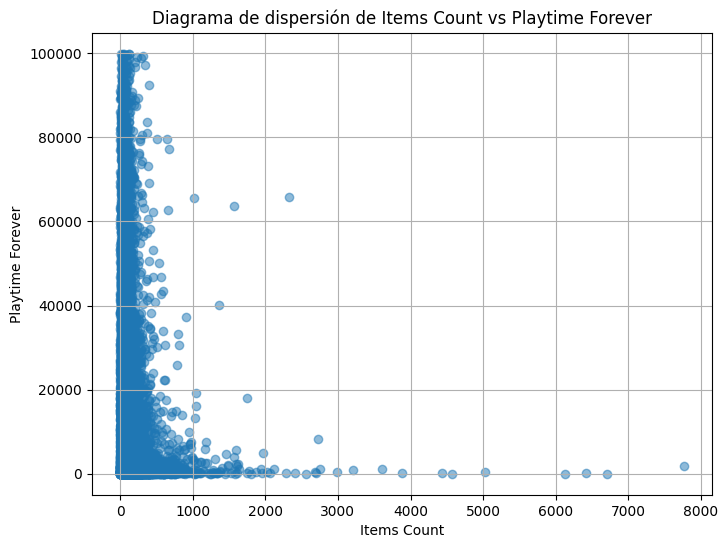

In [43]:

# Crear el diagrama de dispersión
# Recordar que items_count es la cantidad de items por usuario y playtime_forever es la cantidad de horas jugadas por dicho usuario

# Hacemos el grafico indicando un tamaño
plt.figure(figsize=(8, 6))
# Con scatter creamos el grafico de dispersión usando las columnas de nuestro interes
plt.scatter(new_games['items_count'], new_games['playtime_forever'], alpha=0.5)
plt.title('Diagrama de dispersión de Items Count vs Playtime Forever') # Agregamos un titulo
plt.xlabel('Items Count') # Agregamos etiquetas en los ejes
plt.ylabel('Playtime Forever')
plt.grid(True) # Esto activa la cuadrilla en el grafico
plt.show() # Visualizamos el grafico

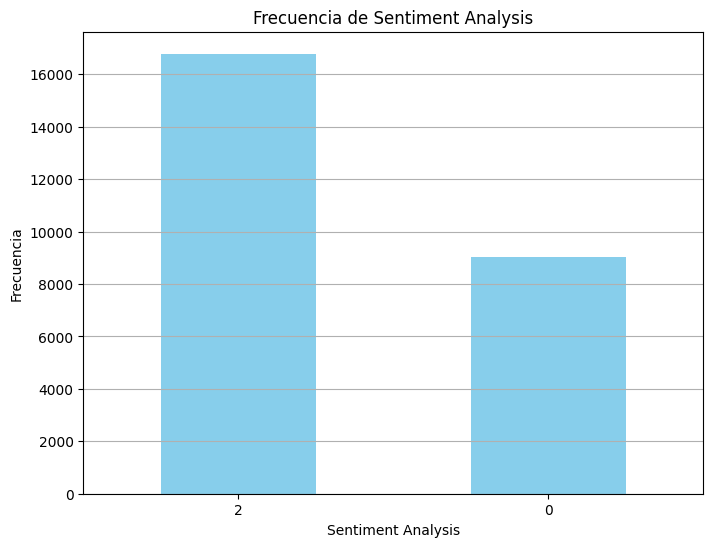

In [44]:
# Contar la frecuencia de cada valor en 'sentiment_analysis'
sentiment_counts = new_games['sentiment_analysis'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Frecuencia de Sentiment Analysis')
plt.xlabel('Sentiment Analysis')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

* La frecuencia más alta del valor 2 en el gráfico de barras indica que muchos usuarios han tenido experiencias positivas con los juegos.
* La predominancia de sentimientos positivos podría sugerir un potencial para que los juegos sean populares entre los jugadores. Las recomendaciones positivas de los usuarios pueden influir en la decisión de otros jugadores de probar los juegos, lo que podría aumentar su popularidad.

## Hare una expansión de la columna 'genres' para poder hacer un grafico y ver que genero frecuentan jugar los usuarios en Steam.

* Este punto decidi dejarlo en esta sección del analisis y no en la preparación de los datos por la perdida significante de los mismos. Pero hare eso mismo para generar sin problema los graficos.

In [45]:
# Convierto las cadenas de la columna 'genres' en listas reales de Python utilizando ast.literal_eval()
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except (SyntaxError, ValueError):
        return np.nan

new_games['genres'] = new_games['genres'].apply(safe_literal_eval)

# Utilizo la función explode() para convertir las listas de la columna 'genres' en filas separadas
df_expanded = new_games.explode('genres')

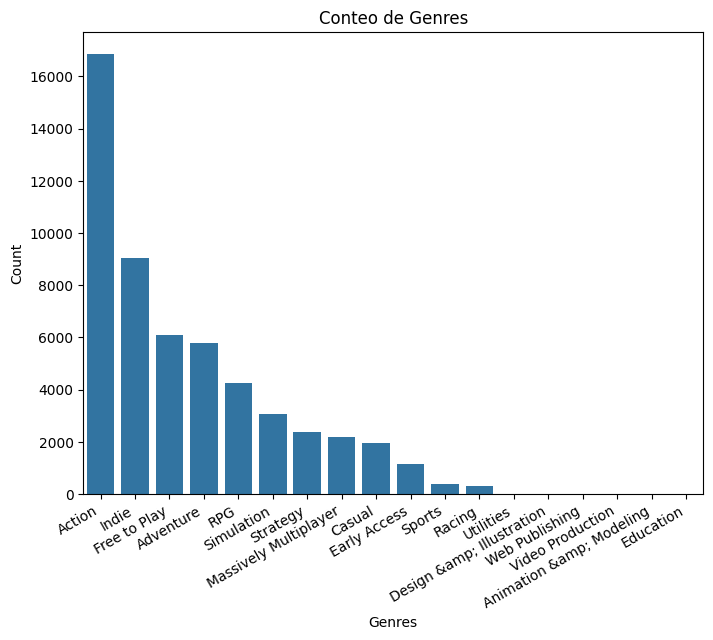

In [46]:
# Contar la frecuencia de cada género en la columna 'genres'
genre_counts = df_expanded['genres'].explode().value_counts()

# Graficar el conteo de géneros
plt.figure(figsize=(8, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values) # Uso el barplot para crear una grafica de barras
plt.title('Conteo de Genres')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right') # Se utiliza para personalizar la etiqueta del eje x, su rotación y lado de rotación
plt.show()

### En este grafico podemos observar que el genero de acción predomina entre los demas. Que con una investigación breve, las empresas desarrolladoras prefieren trabajar sobre juegos de ese tipo de genero por varias razones, como la de que su tiempo de desarrollo lleve menor tiempo que otros, o que se vean influenciados por juegos exitosos del mismo genero ademas de que los jugadores les interese mas este tipo de juegos.

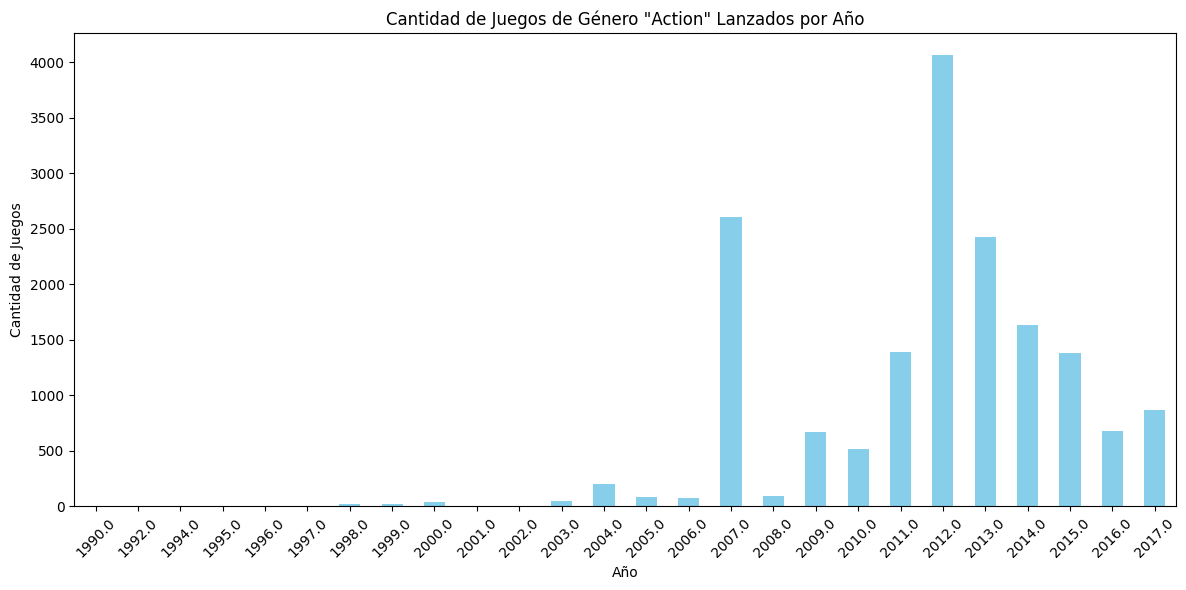

In [47]:
# Definir una función para intentar diferentes formatos de fecha
def try_parsing_date(text):
    for fmt in ('%b %Y', '%Y-%m-%d'):
        try:
            return pd.to_datetime(text, format=fmt)
        except ValueError:
            pass
    return pd.NaT  # Retorna NaT si no se puede convertir ninguna fecha

# Convertir la columna 'release_date' a tipo datetime
df_expanded['release_date'] = df_expanded['release_date'].apply(try_parsing_date)

# Extraer el año de la fecha de lanzamiento
df_expanded['year'] = df_expanded['release_date'].dt.year

# Eliminar filas con valores NaN en la columna 'genres'
df_expanded.dropna(subset=['genres'], inplace=True)

# Filtrar los juegos del género 'Action'
action_games = df_expanded[df_expanded['genres'].str.contains('Action', case=False)]

# Agrupar los juegos de acción por año y contar la cantidad de juegos únicos por año
action_year_counts = action_games.groupby('year').size()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
action_year_counts.plot(kind='bar', color='skyblue')
plt.title('Cantidad de Juegos de Género "Action" Lanzados por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Juegos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Como podemos ver en 2012 hay un incremento, esto podemos pensar que ademas de lo que se dijo antes sobre los desarrolladores tambien hay que tener presente que en ese mismo año estaban en auge los consolas de playstation y xbox.

In [48]:
# Definir una función para realizar el reemplazo de manera más controlada
def replace_price(text):
    if pd.isnull(text):
        return text
    elif 'Play for Free!' in text:
        return '0.0'
    elif 'Free HITMAN™ Holiday Pack' in text:
        return '0.0'
    elif 'Free Mod' in text:
        return '0.0'
    elif 'Free to Play' in text:
        return '0.0'
    elif 'Free' in text:
        return '0.0'
    else:
        return text

# Aplicar la función a la columna 'price'
df_expanded['price'] = df_expanded['price'].apply(replace_price)

print(df_expanded['price'].unique())

['9.99' '14.99' '0.0' '19.99' '39.99' '2.99' '29.99' '24.99' '34.99'
 '0.99' '4.99' '17.99' '3.99' '59.99' '15.99' '5.99' '11.99' '49.99'
 '12.99' '7.99' '59.95' '6.99' '10.99' '13.98' '1.99' '8.99' '13.99'
 '69.99' '20.0' '44.99' '160.91' '7.0' '18.99' '15.0' '54.99'
 'Third-party' '21.99' '189.96' '79.99' '16.06' '32.99' '771.71' '16.99'
 '13.37' '3.49' '7.49' '0.98' '23.99' '23.96' '139.92' '19.98' '0.49'
 'Play WARMACHINE: Tactics Demo' '99.99' 'Play the Demo' '12.89']


In [49]:
# Filtrar los valores numéricos en la columna 'price' y convertirlos a tipo float
df_expanded['price'] = pd.to_numeric(df_expanded['price'], errors='coerce')

# Eliminar las filas que contienen NaN (valores que no se pudieron convertir a float)
df_expanded = df_expanded.dropna(subset=['price'])

# Mostrar el DataFrame resultante
print(df_expanded)

       item_id            user_id  recommend  sentiment_analysis  items_count  \
1       239030            js41637       True                   2        888.0   
1       239030            js41637       True                   2        888.0   
2       224500          evcentric       True                   2        137.0   
2       224500          evcentric       True                   2        137.0   
2       224500          evcentric       True                   2        137.0   
...        ...                ...        ...                 ...          ...   
25797   362890  76561198312638244       True                   2         36.0   
25797   362890  76561198312638244       True                   2         36.0   
25797   362890  76561198312638244       True                   2         36.0   
25798      440        LydiaMorley       True                   2          NaN   
25798      440        LydiaMorley       True                   2          NaN   

            item_name  play

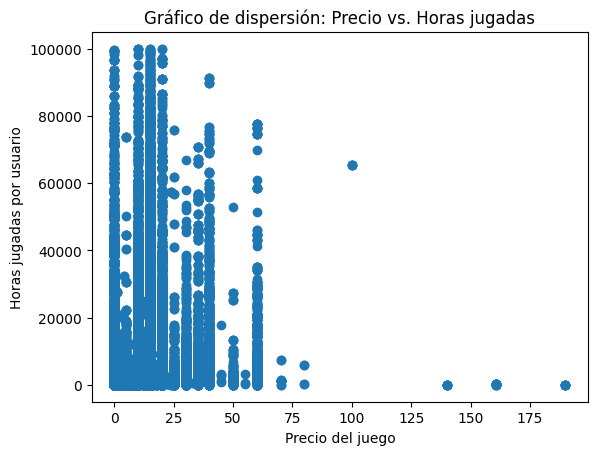

In [50]:
# Crear un gráfico de dispersión
plt.scatter(df_expanded['price'], df_expanded['playtime_forever'])

# Etiquetas de los ejes y título
plt.xlabel('Precio del juego')
plt.ylabel('Horas jugadas por usuario')
plt.title('Gráfico de dispersión: Precio vs. Horas jugadas')

# Mostrar el gráfico
plt.show()

# **VI.II instalación de WordCloud**

In [51]:
pip install wordcloud

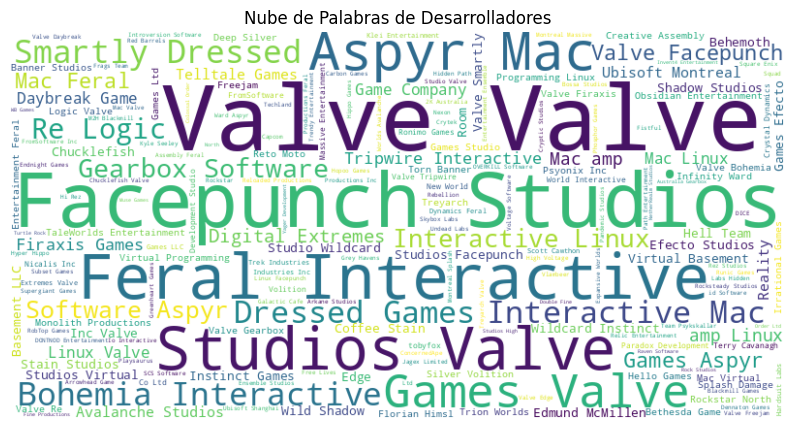

In [52]:
# Eliminar filas con NaN en la columna 'developer'
new_games_cleaned = new_games.dropna(subset=['developer'])

# Concatenar todos los nombres de desarrolladores en una sola cadena
text = ' '.join(new_games_cleaned['developer'])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nube de Palabras de Desarrolladores')
plt.axis('off')
plt.show()

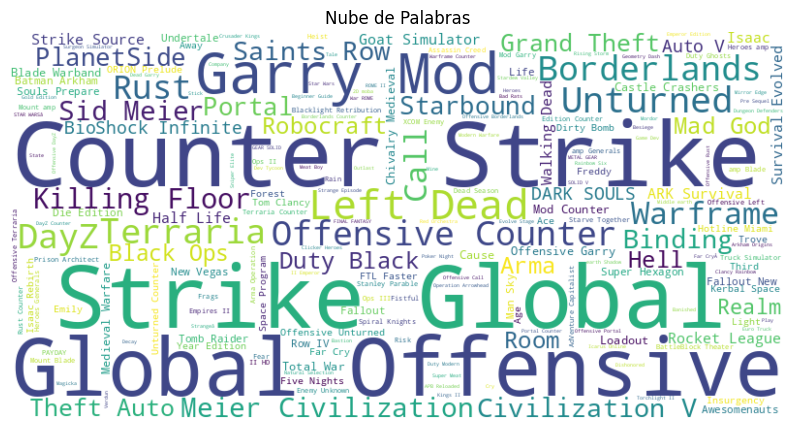

In [53]:
# Eliminar filas con NaN en las columnas relevantes
new_games_cleaned = new_games.dropna(subset=['item_name', 'title'])

# Concatenar todas las palabras de las columnas 'item_name' y 'title'
text = ' '.join(new_games_cleaned['item_name']) + ' ' + ' '.join(new_games_cleaned['title'])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nube de Palabras')
plt.axis('off')
plt.show()